In [1]:
%%capture
!pip install super-gradients==3.1.0

In [2]:
import os
from pathlib import Path
from typing import Dict, Union
import xml.etree.ElementTree as ET
import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-05-02 21:05:22] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-05-02 21:05:30] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-02 21:05:30] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-02 21:05:30] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-02 21:05:30] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-02 21:05:30] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-05-02 21:05:30] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-05-02 21:05:30] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2023-05-02 21:05:30] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2023-05-02 21:05:30] WARNING - env_sanity_check.py - Failed to verify installed packages: omegaconf required but not found
[2023-05-02 21:05:30] WARN

In [3]:

def convert_xml_to_yolo(xml_folder: Union[str, Path], output_folder: Union[str, Path], class_mapping: Dict[str, int]) -> None:
    """
    Convert XML annotations to YOLO format.

    Parameters:
    - xml_folder (Union[str, Path]): Path to the folder containing the XML annotation files.
    - output_folder (Union[str, Path]): Path to the folder where the YOLO annotation files will be saved.
    - class_mapping (Dict[str, int]): Dictionary mapping class names to integer class indices.

    Returns:
    None
    """
    # Convert the input folders to Path objects
    xml_folder = Path(xml_folder)
    output_folder = Path(output_folder)

    # Create the output folder if it does not exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Iterate through the files in the xml_folder
    for xml_file in xml_folder.glob("*.xml"):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get the image size
        size = root.find("size")
        img_width = int(size.find("width").text)
        img_height = int(size.find("height").text)

        # Create a new text file for the YOLO annotations
        yolo_filename = xml_file.with_suffix(".txt").name
        yolo_file_path = output_folder / yolo_filename
        with open(yolo_file_path, "w") as yolo_file:
            for obj in root.iter("object"):
                # Get the class name and index
                class_name = obj.find("name").text
                class_index = class_mapping[class_name]

                # Get the bounding box coordinates
                box = obj.find("bndbox")
                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                # Calculate the YOLO-format coordinates and dimensions
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # Write the annotation in YOLO format
                yolo_file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

class_mapping = {
    "crazing": 0,
    "inclusion": 1,
    "patches": 2,
    "pitted_surface": 3,
    "rolled-in_scale": 4,
    "scratches": 5,
}


In [4]:
# Convert the XML annotations to YOLOv5 format
convert_xml_to_yolo(xml_folder="../input/neu-steel-surface-defect-detect-trainvalid-split/train_annotations",
                    output_folder="./train_annotations",
                    class_mapping=class_mapping)


convert_xml_to_yolo(xml_folder="../input/neu-steel-surface-defect-detect-trainvalid-split/valid_annotations",
                    output_folder="./valid_annotations",
                    class_mapping=class_mapping)

In [5]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'steele-defect-detection' #specify the experiment name

    #dataset params
    DATA_DIR = '.' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train_images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train_annotations' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid_images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid_annotations' #child dir of DATA_DIR where validation labels are


    CLASSES = list(class_mapping.keys()) #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [6]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [7]:
!cp -r ../input/neu-steel-surface-defect-detect-trainvalid-split/train_images . 
!cp -r ../input/neu-steel-surface-defect-detect-trainvalid-split/valid_images . 

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 1700/1700 [00:00<00:00, 4329.45it/s]


Caching annotations: 100%|██████████| 100/100 [00:00<00:00, 4326.70it/s]


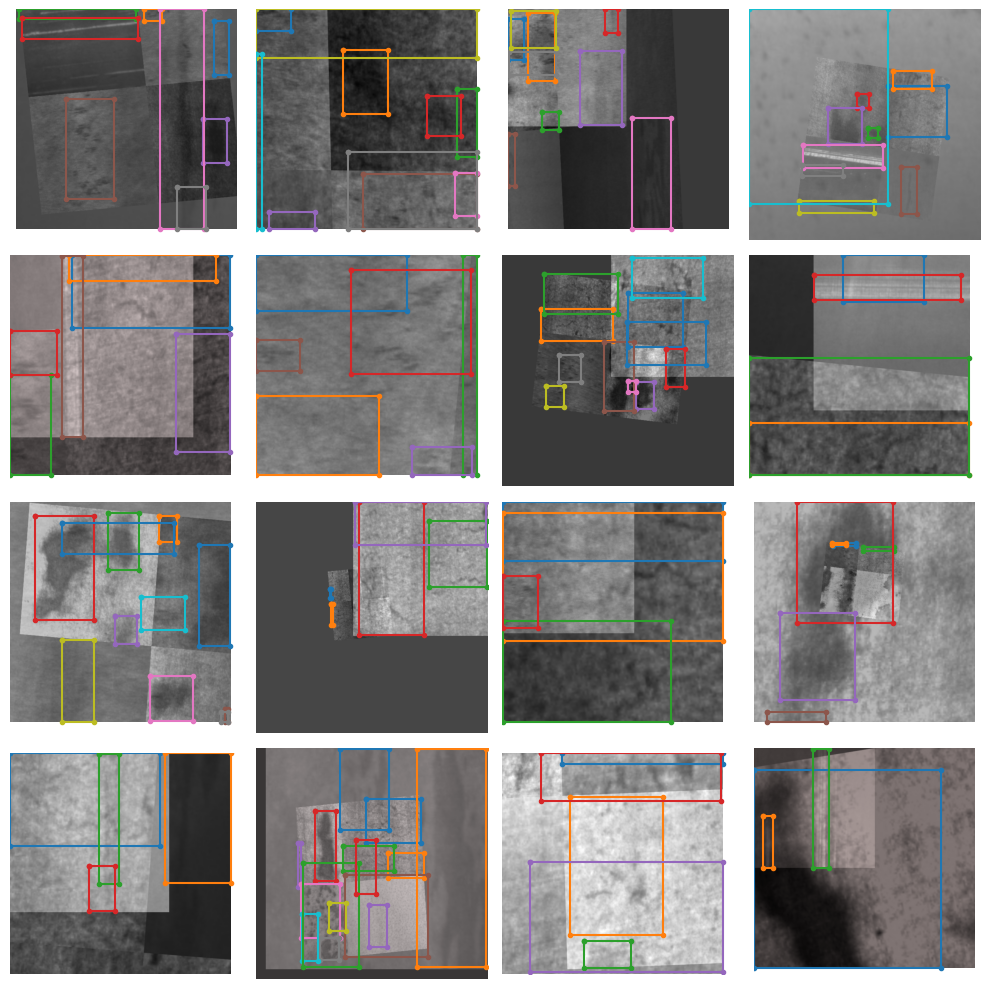

In [9]:
train_data.dataset.plot()

In [10]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-05-02 21:05:48] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


  0%|          | 0.00/256M [00:00<?, ?B/s]

In [11]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [12]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-02 21:06:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/steele-defect-detection/console_May02_21_06_13.txt


[2023-05-02 21:06:18] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1700       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         106        (len(train_loader))
    - Gradient updates per epoch:   106        (len(train_loader) / batch_accumulate)

[2023-05-02 21:06:18] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validation epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.8239
│   ├── Ppyoloeloss/loss_cls = 2.0706
│   ├── Ppyoloeloss/loss_dfl = 1.834
│   └── Ppyoloeloss/loss_iou = 0.3345
└── Validation
    ├── F1@0.50 = 0.0
    ├── Map@0.50 = 0.0004
    ├── Ppyoloeloss/loss = 3.8479
    ├── Ppyoloeloss/loss_cls = 2.1324
    ├── Ppyoloeloss/loss_dfl = 1.7998
    ├── Ppyoloeloss/loss_iou = 0.3262
    ├── Precision@0.50 = 0.0001
    └── Recall@0.50 = 0.0



[2023-05-02 21:08:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:08:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0003955509455408901
Validation epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.9738
│   │   ├── Best until now = 3.8239 (↘ -0.85)
│   │   └── Epoch N-1      = 3.8239 (↘ -0.85)
│   ├── Ppyoloeloss/loss_cls = 1.4264
│   │   ├── Best until now = 2.0706 (↘ -0.6442)
│   │   └── Epoch N-1      = 2.0706 (↘ -0.6442)
│   ├── Ppyoloeloss/loss_dfl = 1.6563
│   │   ├── Best until now = 1.834  (↘ -0.1778)
│   │   └── Epoch N-1      = 1.834  (↘ -0.1778)
│   └── Ppyoloeloss/loss_iou = 0.2877
│       ├── Best until now = 0.3345 (↘ -0.0468)
│       └── Epoch N-1      = 0.3345 (↘ -0.0468)
└── Validation
    ├── F1@0.50 = 0.028
    │   ├── Best until now = 0.0    (↗ 0.028)
    │   └── Epoch N-1      = 0.0    (↗ 0.028)
    ├── Map@0.50 = 0.3278
    │   ├── Best until now = 0.0004 (↗ 0.3274)
    │   └── Epoch N-1      = 0.0004 (↗ 0.3274)
    ├── Ppyoloeloss/loss = 3.0593
    │   ├── Best until now = 3.8479 (↘ -0.7886)
    │   └── Epoch N-1      = 3.8479 (↘ -0.7886)
    ├── Ppyoloeloss/loss_cls = 1.6236
    │   ├── Best unti

[2023-05-02 21:11:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:11:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.32777437567710876
Validation epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.7769
│   │   ├── Best until now = 2.9738 (↘ -0.1969)
│   │   └── Epoch N-1      = 2.9738 (↘ -0.1969)
│   ├── Ppyoloeloss/loss_cls = 1.3133
│   │   ├── Best until now = 1.4264 (↘ -0.1131)
│   │   └── Epoch N-1      = 1.4264 (↘ -0.1131)
│   ├── Ppyoloeloss/loss_dfl = 1.5905
│   │   ├── Best until now = 1.6563 (↘ -0.0658)
│   │   └── Epoch N-1      = 1.6563 (↘ -0.0658)
│   └── Ppyoloeloss/loss_iou = 0.2674
│       ├── Best until now = 0.2877 (↘ -0.0203)
│       └── Epoch N-1      = 0.2877 (↘ -0.0203)
└── Validation
    ├── F1@0.50 = 0.0235
    │   ├── Best until now = 0.028  (↘ -0.0045)
    │   └── Epoch N-1      = 0.028  (↘ -0.0045)
    ├── Map@0.50 = 0.3104
    │   ├── Best until now = 0.3278 (↘ -0.0173)
    │   └── Epoch N-1      = 0.3278 (↘ -0.0173)
    ├── Ppyoloeloss/loss = 2.8529
    │   ├── Best until now = 3.0593 (↘ -0.2065)
    │   └── Epoch N-1      = 3.0593 (↘ -0.2065)
    ├── Ppyoloeloss/loss_cls = 1.4762
    │   ├─

Validation epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.7326
│   │   ├── Best until now = 2.7769 (↘ -0.0443)
│   │   └── Epoch N-1      = 2.7769 (↘ -0.0443)
│   ├── Ppyoloeloss/loss_cls = 1.2981
│   │   ├── Best until now = 1.3133 (↘ -0.0151)
│   │   └── Epoch N-1      = 1.3133 (↘ -0.0151)
│   ├── Ppyoloeloss/loss_dfl = 1.5705
│   │   ├── Best until now = 1.5905 (↘ -0.0199)
│   │   └── Epoch N-1      = 1.5905 (↘ -0.0199)
│   └── Ppyoloeloss/loss_iou = 0.2597
│       ├── Best until now = 0.2674 (↘ -0.0077)
│       └── Epoch N-1      = 0.2674 (↘ -0.0077)
└── Validation
    ├── F1@0.50 = 0.0241
    │   ├── Best until now = 0.028  (↘ -0.0039)
    │   └── Epoch N-1      = 0.0235 (↗ 0.0006)
    ├── Map@0.50 = 0.2211
    │   ├── Best until now = 0.3278 (↘ -0.1067)
    │   └── Epoch N-1      = 0.3104 (↘ -0.0894)
    ├── Ppyoloeloss/loss = 3.1328
    │   ├── Best until now = 2.8529 (↗ 0.28)
    │   └── Epoch N-1      = 2.8529 (↗ 0.28)
    ├── Ppyoloeloss/loss_cls = 1.6667
    │   ├── Best 

Validation epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.661
│   │   ├── Best until now = 2.7326 (↘ -0.0716)
│   │   └── Epoch N-1      = 2.7326 (↘ -0.0716)
│   ├── Ppyoloeloss/loss_cls = 1.2782
│   │   ├── Best until now = 1.2981 (↘ -0.0199)
│   │   └── Epoch N-1      = 1.2981 (↘ -0.0199)
│   ├── Ppyoloeloss/loss_dfl = 1.5271
│   │   ├── Best until now = 1.5705 (↘ -0.0434)
│   │   └── Epoch N-1      = 1.5705 (↘ -0.0434)
│   └── Ppyoloeloss/loss_iou = 0.2477
│       ├── Best until now = 0.2597 (↘ -0.012)
│       └── Epoch N-1      = 0.2597 (↘ -0.012)
└── Validation
    ├── F1@0.50 = 0.0371
    │   ├── Best until now = 0.028  (↗ 0.0091)
    │   └── Epoch N-1      = 0.0241 (↗ 0.013)
    ├── Map@0.50 = 0.3237
    │   ├── Best until now = 0.3278 (↘ -0.0041)
    │   └── Epoch N-1      = 0.2211 (↗ 0.1027)
    ├── Ppyoloeloss/loss = 2.8398
    │   ├── Best until now = 2.8529 (↘ -0.013)
    │   └── Epoch N-1      = 3.1328 (↘ -0.293)
    ├── Ppyoloeloss/loss_cls = 1.4548
    │   ├── Best un

Validation epoch 5: 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 2.6233
│   │   ├── Best until now = 2.661  (↘ -0.0378)
│   │   └── Epoch N-1      = 2.661  (↘ -0.0378)
│   ├── Ppyoloeloss/loss_cls = 1.2668
│   │   ├── Best until now = 1.2782 (↘ -0.0115)
│   │   └── Epoch N-1      = 1.2782 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_dfl = 1.5065
│   │   ├── Best until now = 1.5271 (↘ -0.0206)
│   │   └── Epoch N-1      = 1.5271 (↘ -0.0206)
│   └── Ppyoloeloss/loss_iou = 0.2413
│       ├── Best until now = 0.2477 (↘ -0.0064)
│       └── Epoch N-1      = 0.2477 (↘ -0.0064)
└── Validation
    ├── F1@0.50 = 0.0322
    │   ├── Best until now = 0.0371 (↘ -0.0049)
    │   └── Epoch N-1      = 0.0371 (↘ -0.0049)
    ├── Map@0.50 = 0.3803
    │   ├── Best until now = 0.3278 (↗ 0.0525)
    │   └── Epoch N-1      = 0.3237 (↗ 0.0566)
    ├── Ppyoloeloss/loss = 2.7146
    │   ├── Best until now = 2.8398 (↘ -0.1253)
    │   └── Epoch N-1      = 2.8398 (↘ -0.1253)
    ├── Ppyoloeloss/loss_cls = 1.3947
    │   ├── 

[2023-05-02 21:20:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:20:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.38032278418540955
Validation epoch 6: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 2.548
│   │   ├── Best until now = 2.6233 (↘ -0.0753)
│   │   └── Epoch N-1      = 2.6233 (↘ -0.0753)
│   ├── Ppyoloeloss/loss_cls = 1.2483
│   │   ├── Best until now = 1.2668 (↘ -0.0184)
│   │   └── Epoch N-1      = 1.2668 (↘ -0.0184)
│   ├── Ppyoloeloss/loss_dfl = 1.4584
│   │   ├── Best until now = 1.5065 (↘ -0.0481)
│   │   └── Epoch N-1      = 1.5065 (↘ -0.0481)
│   └── Ppyoloeloss/loss_iou = 0.2282
│       ├── Best until now = 0.2413 (↘ -0.0131)
│       └── Epoch N-1      = 0.2413 (↘ -0.0131)
└── Validation
    ├── F1@0.50 = 0.0395
    │   ├── Best until now = 0.0371 (↗ 0.0024)
    │   └── Epoch N-1      = 0.0322 (↗ 0.0073)
    ├── Map@0.50 = 0.45
    │   ├── Best until now = 0.3803 (↗ 0.0697)
    │   └── Epoch N-1      = 0.3803 (↗ 0.0697)
    ├── Ppyoloeloss/loss = 2.6619
    │   ├── Best until now = 2.7146 (↘ -0.0527)
    │   └── Epoch N-1      = 2.7146 (↘ -0.0527)
    ├── Ppyoloeloss/loss_cls = 1.3722
    │   ├── Best 

[2023-05-02 21:23:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:23:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4499746263027191
Validation epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 2.4938
│   │   ├── Best until now = 2.548  (↘ -0.0542)
│   │   └── Epoch N-1      = 2.548  (↘ -0.0542)
│   ├── Ppyoloeloss/loss_cls = 1.22
│   │   ├── Best until now = 1.2483 (↘ -0.0283)
│   │   └── Epoch N-1      = 1.2483 (↘ -0.0283)
│   ├── Ppyoloeloss/loss_dfl = 1.4294
│   │   ├── Best until now = 1.4584 (↘ -0.029)
│   │   └── Epoch N-1      = 1.4584 (↘ -0.029)
│   └── Ppyoloeloss/loss_iou = 0.2236
│       ├── Best until now = 0.2282 (↘ -0.0046)
│       └── Epoch N-1      = 0.2282 (↘ -0.0046)
└── Validation
    ├── F1@0.50 = 0.039
    │   ├── Best until now = 0.0395 (↘ -0.0005)
    │   └── Epoch N-1      = 0.0395 (↘ -0.0005)
    ├── Map@0.50 = 0.4759
    │   ├── Best until now = 0.45   (↗ 0.0259)
    │   └── Epoch N-1      = 0.45   (↗ 0.0259)
    ├── Ppyoloeloss/loss = 2.6076
    │   ├── Best until now = 2.6619 (↘ -0.0543)
    │   └── Epoch N-1      = 2.6619 (↘ -0.0543)
    ├── Ppyoloeloss/loss_cls = 1.358
    │   ├── Best u

[2023-05-02 21:25:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:25:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.47591713070869446
Validation epoch 8: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 2.4284
│   │   ├── Best until now = 2.4938 (↘ -0.0654)
│   │   └── Epoch N-1      = 2.4938 (↘ -0.0654)
│   ├── Ppyoloeloss/loss_cls = 1.1955
│   │   ├── Best until now = 1.22   (↘ -0.0245)
│   │   └── Epoch N-1      = 1.22   (↘ -0.0245)
│   ├── Ppyoloeloss/loss_dfl = 1.3915
│   │   ├── Best until now = 1.4294 (↘ -0.0379)
│   │   └── Epoch N-1      = 1.4294 (↘ -0.0379)
│   └── Ppyoloeloss/loss_iou = 0.2149
│       ├── Best until now = 0.2236 (↘ -0.0088)
│       └── Epoch N-1      = 0.2236 (↘ -0.0088)
└── Validation
    ├── F1@0.50 = 0.0426
    │   ├── Best until now = 0.0395 (↗ 0.003)
    │   └── Epoch N-1      = 0.039  (↗ 0.0035)
    ├── Map@0.50 = 0.5175
    │   ├── Best until now = 0.4759 (↗ 0.0416)
    │   └── Epoch N-1      = 0.4759 (↗ 0.0416)
    ├── Ppyoloeloss/loss = 2.5479
    │   ├── Best until now = 2.6076 (↘ -0.0597)
    │   └── Epoch N-1      = 2.6076 (↘ -0.0597)
    ├── Ppyoloeloss/loss_cls = 1.3078
    │   ├── Bes

[2023-05-02 21:28:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:28:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5175294280052185
Validation epoch 9: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 2.4036
│   │   ├── Best until now = 2.4284 (↘ -0.0248)
│   │   └── Epoch N-1      = 2.4284 (↘ -0.0248)
│   ├── Ppyoloeloss/loss_cls = 1.1785
│   │   ├── Best until now = 1.1955 (↘ -0.017)
│   │   └── Epoch N-1      = 1.1955 (↘ -0.017)
│   ├── Ppyoloeloss/loss_dfl = 1.3845
│   │   ├── Best until now = 1.3915 (↘ -0.0069)
│   │   └── Epoch N-1      = 1.3915 (↘ -0.0069)
│   └── Ppyoloeloss/loss_iou = 0.2131
│       ├── Best until now = 0.2149 (↘ -0.0017)
│       └── Epoch N-1      = 0.2149 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.0482
    │   ├── Best until now = 0.0426 (↗ 0.0057)
    │   └── Epoch N-1      = 0.0426 (↗ 0.0057)
    ├── Map@0.50 = 0.5266
    │   ├── Best until now = 0.5175 (↗ 0.0091)
    │   └── Epoch N-1      = 0.5175 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 2.5202
    │   ├── Best until now = 2.5479 (↘ -0.0276)
    │   └── Epoch N-1      = 2.5479 (↘ -0.0276)
    ├── Ppyoloeloss/loss_cls = 1.3013
    │   ├── Best

[2023-05-02 21:30:55] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/ckpt_best.pth
[2023-05-02 21:30:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5266191363334656
[2023-05-02 21:31:22] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 10: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.4036
│   │   ├── Best until now = 2.4284 (↘ -0.0248)
│   │   └── Epoch N-1      = 2.4284 (↘ -0.0248)
│   ├── Ppyoloeloss/loss_cls = 1.1785
│   │   ├── Best until now = 1.1955 (↘ -0.017)
│   │   └── Epoch N-1      = 1.1955 (↘ -0.017)
│   ├── Ppyoloeloss/loss_dfl = 1.3845
│   │   ├── Best until now = 1.3915 (↘ -0.0069)
│   │   └── Epoch N-1      = 1.3915 (↘ -0.0069)
│   └── Ppyoloeloss/loss_iou = 0.2131
│       ├── Best until now = 0.2149 (↘ -0.0017)
│       └── Epoch N-1      = 0.2149 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.0801
    │   ├── Best until now = 0.0482 (↗ 0.0319)
    │   └── Epoch N-1      = 0.0482 (↗ 0.0319)
    ├── Map@0.50 = 0.4641
    │   ├── Best until now = 0.5266 (↘ -0.0625)
    │   └── Epoch N-1      = 0.5266 (↘ -0.0625)
    ├── Ppyoloeloss/loss = 2.5008
    │   ├── Best until now = 2.5202 (↘ -0.0195)
    │   └── Epoch N-1      = 2.5202 (↘ -0.0195)
    ├── Ppyoloeloss/loss_cls = 1.2641
    │   ├── B

In [13]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

In [14]:
trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=config.NUM_CLASSES, 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Test:  83%|████████▎ | 5/6 [00:02<00:00,  2.17it/s]

{'PPYoloELoss/loss_cls': 1.2768956,
 'PPYoloELoss/loss_iou': 0.20479532,
 'PPYoloELoss/loss_dfl': 1.4099661,
 'PPYoloELoss/loss': 2.4938672,
 'Precision@0.50': tensor(0.0251),
 'Recall@0.50': tensor(1.),
 'mAP@0.50': tensor(0.5327),
 'F1@0.50': tensor(0.0487)}

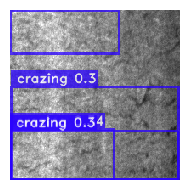

In [15]:
best_model.predict('train_images/crazing_10.jpg', conf=0.3).show()